# # Original files (load + rename + drop id)

In [242]:
import pandas as pd

# Load full dataset
data = pd.read_csv("/Users/vedantdilip/Documents/ML_Projects/Price-Prediction_Regression/GemstoneData.csv")

# Rename geometry columns
data = data.rename(columns={"x": "length", "y": "width", "z": "depth_mm"})

# Drop non-predictive id if present
if "id" in data.columns:
    data = data.drop(columns=["id"])

data.head(3), data.shape


(   carat        cut color clarity  depth  table  length  width  depth_mm  \
 0   1.52    Premium     F     VS2   62.2   58.0    7.27   7.33      4.55   
 1   2.03  Very Good     J     SI2   62.0   58.0    8.06   8.12      5.05   
 2   0.70      Ideal     G     VS1   61.2   57.0    5.69   5.73      3.50   
 
    price  
 0  13619  
 1  13387  
 2   2772  ,
 (193573, 10))

# Preprocessing (columns, pipelines, split)

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Features/target
feature_cols = ["carat","cut","color","clarity","depth","table","length","width","depth_mm"]
X = data[feature_cols].copy()
y = data["price"].copy()

# Train/test split FIRST (avoid leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Column types
num_cols = ["carat","depth","table","length","width","depth_mm"]
cat_cols = ["cut","color","clarity"]

# Ordinal orders
cut_order     = ["Fair","Good","Very Good","Premium","Ideal"]
color_order   = ["J","I","H","G","F","E","D"]   # D is best
clarity_order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]

# Pipelines
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])

cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("enc", OrdinalEncoder(categories=[cut_order, color_order, clarity_order],
                                            handle_unknown="use_encoded_value", unknown_value=-1))])

# Combined preprocessor
preprocessor = ColumnTransformer([("num", num_pipe, num_cols),
                                  ("cat", cat_pipe, cat_cols)],
                                 verbose_feature_names_out=False)


In [2]:
# compare_imputers_fixed.py
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Enable IterativeImputer (MICE)
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

# ---------- Load & prepare ----------
data = pd.read_csv("/Users/vedantdilip/Documents/ML_Projects/Price-Prediction_Regression/GemstoneData.csv")
data = data.rename(columns={"x": "length", "y": "width", "z": "depth_mm"})
if "id" in data.columns:
    data = data.drop(columns=["id"])

feature_cols = ["carat","cut","color","clarity","depth","table","length","width","depth_mm"]
target_col = "price"

X = data[feature_cols].copy()
y = data[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

num_cols = ["carat","depth","table","length","width","depth_mm"]
cat_cols = ["cut","color","clarity"]

cut_order     = ["Fair","Good","Very Good","Premium","Ideal"]
color_order   = ["J","I","H","G","F","E","D"]  # worst -> best
clarity_order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]

def make_preprocessor(numeric_imputer):
    num_pipe = Pipeline([
        ("imputer", numeric_imputer),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("enc", OrdinalEncoder(
            categories=[cut_order, color_order, clarity_order],
            handle_unknown="use_encoded_value", unknown_value=-1
        )),
        ("scaler", StandardScaler())
    ])
    return ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ], verbose_feature_names_out=False)

def rmse(y_true, y_pred):
    # Version-agnostic RMSE (works without the 'squared' arg)
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

imputers = {
    "Simple(mean)":    SimpleImputer(strategy="mean"),
    "Simple(median)":  SimpleImputer(strategy="median"),
    "KNN(k=5)":        KNNImputer(n_neighbors=5, weights="distance"),
    "MICE(Iterative)": IterativeImputer(random_state=42, sample_posterior=False, max_iter=10)
}

results = []
for name, num_imputer in imputers.items():
    pre = make_preprocessor(num_imputer)
    pipe = Pipeline([("pre", pre), ("model", LinearRegression())])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results.append({
        "Imputer": name,
        "R2": r2_score(y_test, preds),
        "RMSE": rmse(y_test, preds)
    })

df = pd.DataFrame(results).sort_values(["RMSE","R2"], ascending=[True, False]).reset_index(drop=True)
print(df.to_string(index=False))


        Imputer       R2        RMSE
   Simple(mean) 0.936291 1014.629663
 Simple(median) 0.936291 1014.629663
       KNN(k=5) 0.936291 1014.629663
MICE(Iterative) 0.936291 1014.629663


In [3]:
print("Numeric missing values:")
print(X_train[num_cols].isnull().sum())

print("\nCategorical missing values:")
print(X_train[cat_cols].isnull().sum())


Numeric missing values:
carat       0
depth       0
table       0
length      0
width       0
depth_mm    0
dtype: int64

Categorical missing values:
cut        0
color      0
clarity    0
dtype: int64


In [6]:
# Check missing values
print("Numeric missing values:")
print(X_train[num_cols].isnull().sum())

print("\nCategorical missing values:")
print(X_train[cat_cols].isnull().sum())

# Check outliers in numeric columns (IQR method)
print("\nOutlier counts per numeric column (IQR method):")
for col in num_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((X_train[col] < lower_bound) | (X_train[col] > upper_bound)).sum()
    print(f"{col}: {outlier_count} outliers")


Numeric missing values:
carat       0
depth       0
table       0
length      0
width       0
depth_mm    0
dtype: int64

Categorical missing values:
cut        0
color      0
clarity    0
dtype: int64

Outlier counts per numeric column (IQR method):
carat: 5431 outliers
depth: 6947 outliers
table: 3064 outliers
length: 13 outliers
width: 10 outliers
depth_mm: 14 outliers


In [5]:
# compare_scalers.py
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OrdinalEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ---------- Load & prepare ----------
data = pd.read_csv("/Users/vedantdilip/Documents/ML_Projects/Price-Prediction_Regression/GemstoneData.csv")
data = data.rename(columns={"x": "length", "y": "width", "z": "depth_mm"})
if "id" in data.columns:
    data = data.drop(columns=["id"])

feature_cols = ["carat","cut","color","clarity","depth","table","length","width","depth_mm"]
target_col = "price"

X = data[feature_cols].copy()
y = data[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

num_cols = ["carat","depth","table","length","width","depth_mm"]
cat_cols = ["cut","color","clarity"]

cut_order     = ["Fair","Good","Very Good","Premium","Ideal"]
color_order   = ["J","I","H","G","F","E","D"]  # worst -> best
clarity_order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]

# ---------- Helper: build preprocessor with a given scaler ----------
def make_preprocessor(numeric_scaler):
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", numeric_scaler)
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("enc", OrdinalEncoder(
            categories=[cut_order, color_order, clarity_order],
            handle_unknown="use_encoded_value", unknown_value=-1
        )),
        ("scaler", numeric_scaler)
    ])
    pre = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ], verbose_feature_names_out=False)
    return pre

# ---------- Define scalers to compare ----------
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

results = []

for name, scaler in scalers.items():
    preprocessor = make_preprocessor(scaler)
    model = LinearRegression()
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)   # no 'squared' arg
    rmse = np.sqrt(mse)                       # manual RMSE
    results.append({"Scaler": name, "R2": r2, "RMSE": rmse})

# ---------- Show results ----------
df_results = pd.DataFrame(results).sort_values(["RMSE","R2"], ascending=[True, False]).reset_index(drop=True)
print(df_results.to_string(index=False))


        Scaler       R2        RMSE
StandardScaler 0.936291 1014.629663
  RobustScaler 0.936291 1014.629663
  MinMaxScaler 0.936291 1014.629663


# EDA (quick + simple)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   carat     193573 non-null  float64
 1   cut       193573 non-null  object 
 2   color     193573 non-null  object 
 3   clarity   193573 non-null  object 
 4   depth     193573 non-null  float64
 5   table     193573 non-null  float64
 6   length    193573 non-null  float64
 7   width     193573 non-null  float64
 8   depth_mm  193573 non-null  float64
 9   price     193573 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 14.8+ MB
None


,count,mean,std,min,25%,50%,75%,max
carat,193573.0,0.790688,0.462688,0.2,0.40,0.70,1.03,3.50
depth,193573.0,61.820574,1.081704,52.1,61.30,61.90,62.40,71.60
table,193573.0,57.227675,1.918844,49.0,56.00,57.00,58.00,79.00
length,193573.0,5.715312,1.109422,0.0,4.70,5.70,6.51,9.65
width,193573.0,5.720094,1.102333,0.0,4.71,5.72,6.51,10.01
depth_mm,193573.0,3.534246,0.688922,0.0,2.90,3.53,4.03,31.30
price,193573.0,3969.155414,4034.374138,326.0,951.00,2401.00,5408.00,18818.00


cut :
 cut
Ideal        92454
Premium      49910
Very Good    37566
Good         11622
Fair          2021
Name: count, dtype: int64 

color :
 color
G    44391
E    35869
F    34258
H    30799
D    24286
I    17514
J     6456
Name: count, dtype: int64 

clarity :
 clarity
SI1     53272
VS2     48027
VS1     30669
SI2     30484
VVS2    15762
VVS1    10628
IF       4219
I1        512
Name: count, dtype: int64 



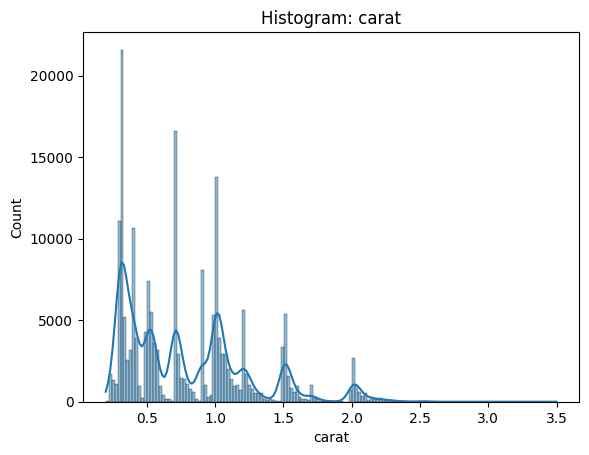

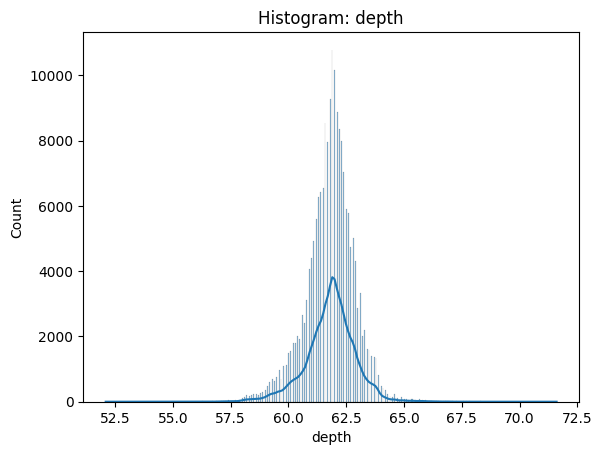

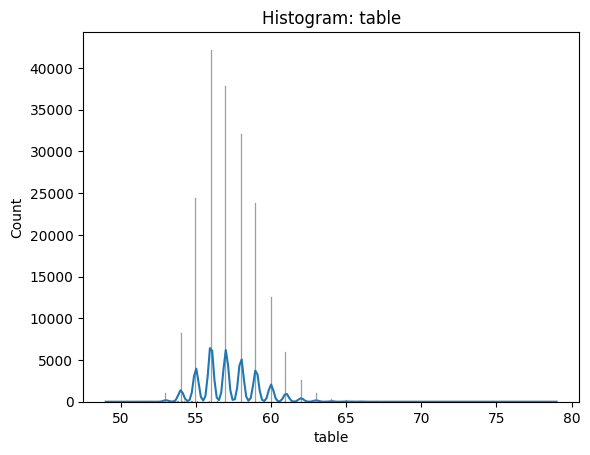

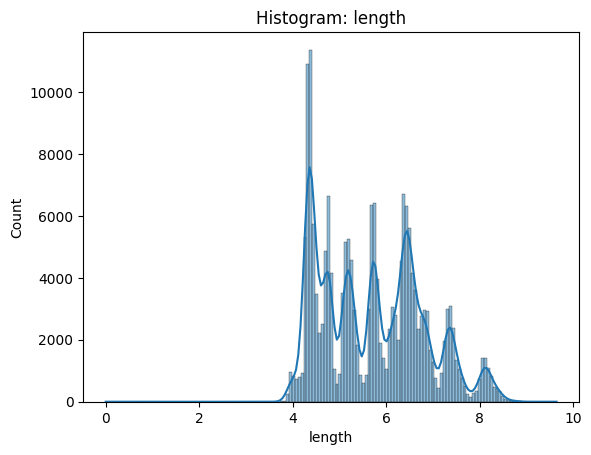

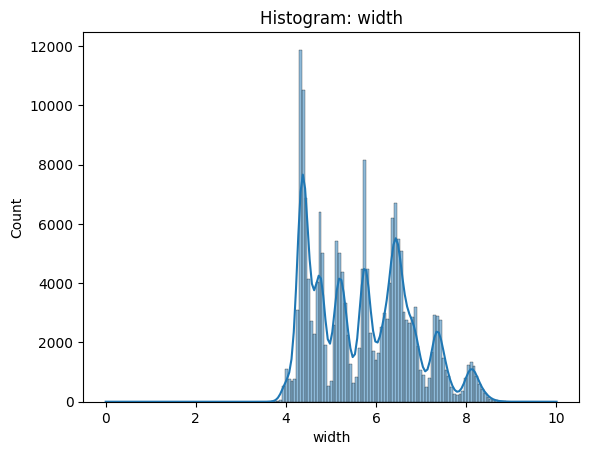

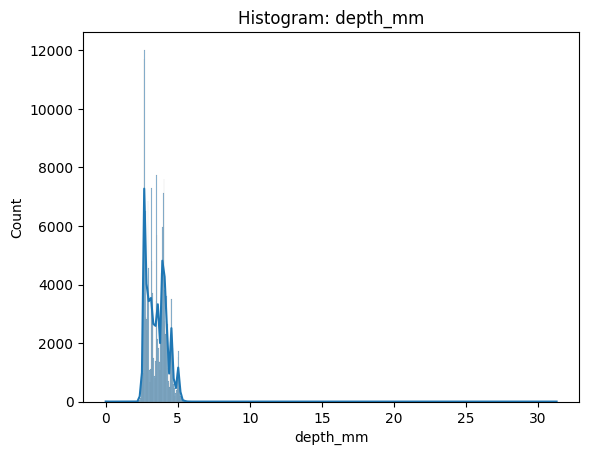

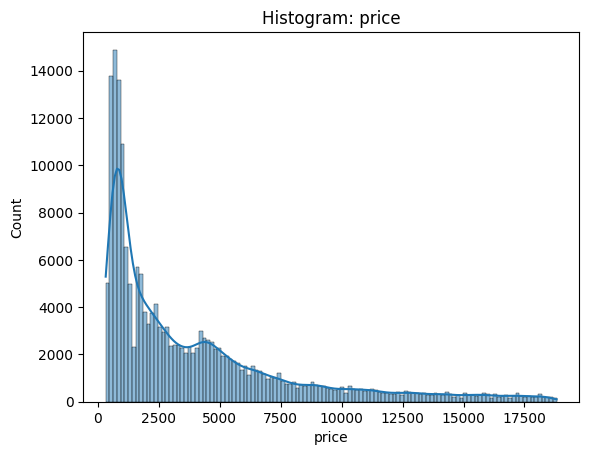

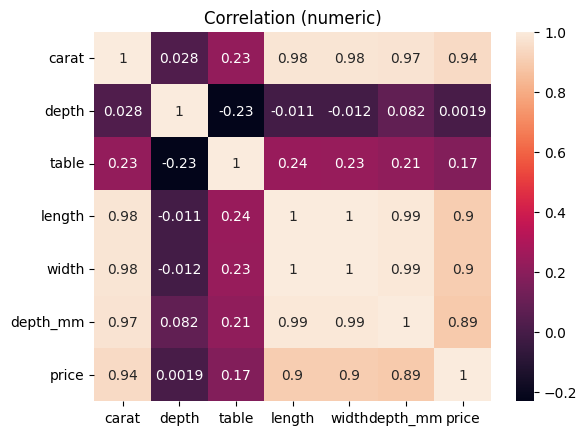

In [244]:
# quick structure
print(data.info())

# numeric summary
display(data[num_cols + ["price"]].describe().T)

# category counts
for c in cat_cols:
    print(c, ":\n", data[c].value_counts(), "\n")

# quick histograms
import matplotlib.pyplot as plt
import seaborn as sns
for c in num_cols + ["price"]:
    sns.histplot(data[c], kde=True)
    plt.title(f"Histogram: {c}")
    plt.show()

# correlation heatmap (numeric)
sns.heatmap(data[num_cols + ["price"]].corr(), annot=True)
plt.title("Correlation (numeric)")
plt.show()


# Models & metrics (R², RMSE, MAE) — simple compare

In [245]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6,
                            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
}

results = []
for name, est in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", est)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    r2 = r2_score(y_test, pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
    mae = mean_absolute_error(y_test, pred)

    results.append({"Model": name, "R2": round(r2,4), "RMSE": round(rmse,2), "MAE": round(mae,2)})

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print(results_df)


              Model      R2     RMSE     MAE
5           XGBoost  0.9786   588.12  296.35
4      RandomForest  0.9770   609.31  308.88
0  LinearRegression  0.9363  1014.63  675.08
1             Lasso  0.9363  1014.63  675.08
2             Ridge  0.9363  1014.63  675.11
3        ElasticNet  0.9362  1015.10  677.52


# MLflow (log only metrics; one run per model)

In [248]:
import os, mlflow

# Pick ONE path and stick to it everywhere (training, reporting, UI)
TRACKING_DIR = "/Users/vedantdilip/Price-Prediction_Regression/experiment/mlruns"

# Make sure MLflow’s folders exist
os.makedirs(TRACKING_DIR, exist_ok=True)
os.makedirs(os.path.join(TRACKING_DIR, ".trash"), exist_ok=True)

# Point MLflow to this store and select/create the experiment
mlflow.set_tracking_uri(f"file://{TRACKING_DIR}")
mlflow.set_experiment("Gemstone_Price_Regression")

print("Tracking URI set to:", mlflow.get_tracking_uri())


2025/08/10 00:39:13 INFO mlflow.tracking.fluent: Experiment with name 'Gemstone_Price_Regression' does not exist. Creating a new experiment.


Tracking URI set to: file:///Users/vedantdilip/Price-Prediction_Regression/experiment/mlruns


# Tiny report (for VS Code)

In [249]:
import os

os.makedirs("reports", exist_ok=True)
csv_path = "reports/model_metrics.csv"
txt_path = "reports/model_recommendation.txt"

results_df.to_csv(csv_path, index=False)

best = results_df.iloc[0]
with open(txt_path, "w") as f:
    f.write("Gemstone Price Models — Simple Report\n")
    f.write("-------------------------------------\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\nRecommendation:\n")
    f.write(f"- Choose **{best['Model']}** → R2={best['R2']}, RMSE={best['RMSE']}, MAE={best['MAE']}\n")

print("Saved:")
print(" -", os.path.abspath(csv_path))
print(" -", os.path.abspath(txt_path))


Saved:
 - /Users/vedantdilip/Price-Prediction_Regression/experiment/reports/model_metrics.csv
 - /Users/vedantdilip/Price-Prediction_Regression/experiment/reports/model_recommendation.txt


In [252]:
import mlflow

# --- keep your tracking URI consistent with where you logged earlier ---
TRACKING_DIR = "/Users/vedantdilip/Price-Prediction_Regression/experiment/mlruns"
mlflow.set_tracking_uri(f"file://{TRACKING_DIR}")
mlflow.set_experiment("Gemstone_Price_Regression")

# --- reset any ghost/lingering active run (robust) ---
try:
    while mlflow.active_run() is not None:
        try:
            mlflow.end_run()
        except Exception:
            # force-clear local state if the run can't be found in the store
            from mlflow.tracking.fluent import _active_run_stack, _last_active_run_id
            _active_run_stack.clear()
            _last_active_run_id.set(None)
            break
except Exception:
    pass  # if anything odd happens, just move on

# --- minimal logging: ONLY R2, RMSE, MAE per model ---
for row in results_df.itertuples(index=False):
    with mlflow.start_run(run_name=row.Model):
        mlflow.log_param("model_name", row.Model)
        mlflow.log_metric("R2",   float(row.R2))
        mlflow.log_metric("RMSE", float(row.RMSE))
        mlflow.log_metric("MAE",  float(row.MAE))
